In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import os
import PIL
import cv2

import tensorflow_hub as hub 

In [3]:
Image_shape = (224,224)

classifier = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=Image_shape+(3,))
])

In [5]:
Image_shape+(3,)

(224, 224, 3)

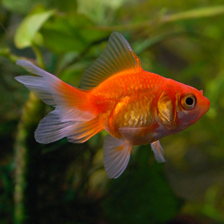

In [8]:
gold_fish = PIL.Image.open("goldfish.jpg").resize(Image_shape)
gold_fish

In [9]:
gold_fish = np.array(gold_fish)/255
gold_fish.shape

(224, 224, 3)

In [11]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [14]:
prediction = classifier.predict(gold_fish[np.newaxis,...])
prediction.shape

1/1 [==============================] - 0s 36ms/step


(1, 1001)

In [19]:
prediction = np.argmax(prediction)

In [20]:
image_labels = []

with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()

In [21]:
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [22]:
image_labels[prediction]

'goldfish'

In [23]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)

228813984/228813984 [==============================] - 33s 0us/step


In [24]:
data_dir

'.\\datasets\\flower_photos'

In [25]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [31]:
roses = list(data_dir.glob('roses/*.jpg'))
len(roses)

641

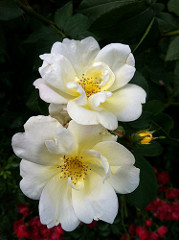

In [32]:
PIL.Image.open(str(roses[0]))

In [33]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [35]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [37]:
X = np.array(X)
y = np.array(y)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [39]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [40]:
X[0].shape

(224, 224, 3)

In [41]:
pred = classifier.predict(np.array([X[0],X[1],X[2]]))
pred = np.argmax(pred, axis=1)
pred

1/1 [==============================] - 1s 882ms/step


array([795, 880, 795], dtype=int64)

In [42]:
image_labels[795], image_labels[880]

('shower curtain', 'umbrella')

In [43]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model,input_shape=(224,224,3),trainable=False)

In [44]:
num_of_flowers = 5

model = Sequential([
    
    pretrained_model_without_top_layer,
    layers.Dense(num_of_flowers)
    
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 54s 591ms/step - loss: 0.7543 - acc: 0.7151
Epoch 2/5
86/86 [==============================] - 49s 567ms/step - loss: 0.3988 - acc: 0.8659
Epoch 3/5
86/86 [==============================] - 46s 535ms/step - loss: 0.3156 - acc: 0.8957
Epoch 4/5
86/86 [==============================] - 47s 546ms/step - loss: 0.2616 - acc: 0.9164
Epoch 5/5
86/86 [==============================] - 2303s 27s/step - loss: 0.2263 - acc: 0.9339


In [46]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 20s 641ms/step - loss: 0.3700 - acc: 0.8671


[0.3699798583984375, 0.8671023845672607]